__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Чт 13 июн 2024 12:07:48 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_flat.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

16906

,title,address,latitude,longitude,priceM,dt
1223,"1-комн. квартира, 28,4 м², 2/2 этаж","севастополь,р-н нахимовский,улица будищева,52а",44.599913,33.539985,4.80,2024-06-07
2463,"студия, 28 м², 2/3 этаж","севастополь,р-н гагаринский,улица хрусталева,132",44.550768,33.524704,2.60,2024-06-11
13124,"2-к. квартира, 56 м², 2/5 эт.","севастополь,улица адмирала юмашева,3",44.59508,33.45937,10.80,2024-06-13


In [4]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# df[ (df['place']=='sevastopol') & (df['address'].str.match(r'.*Судак.*')) ][cols]

---

In [5]:
df_ = pd.read_pickle('data/2023/data_flat.pkl').rename(columns={'adr':'address'})
display( len(df_) )
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page','cian_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

108483

85199

,title,address,latitude,longitude,priceM,dt,url
49046,"2-к. квартира, 41,8 м², 1/5 эт.","Севастополь, улица Горпищенко, 70",44.594515,33.561993,4.80,2022-09-22,https://avito.ru/2537624458
7868,"2-к. апартаменты, 55 м², 4/6 эт.","Севастополь,Фиолентовское шоссе , 134 к6",44.504409,33.486032,9.94,2022-08-31,https://avito.ru/2321118065
60988,"6-к. квартира, 304 м², 3/4 эт.","Севастополь, улица Ленина, 76",44.601909,33.524659,43.50,2022-10-14,https://avito.ru/2480936631


In [6]:
df_['dt'].drop_duplicates()

0        2022-08-26
3487     2022-08-29
6945     2022-08-31
10365    2022-09-01
13796    2022-09-02
17315    2022-09-05
20791    2022-09-06
24219    2022-09-07
27334    2022-09-08
30604    2022-09-12
33710    2022-09-13
37123    2022-09-15
40655    2022-09-16
44046    2022-09-19
47601    2022-09-22
51232    2022-09-26
54808    2022-10-08
58407    2022-10-14
61881    2022-11-01
65025    2022-11-04
68169    2022-11-07
71426    2022-11-15
74644    2022-11-28
78240    2023-01-10
81278    2024-06-04
83533    2024-06-05
Name: dt, dtype: object

In [7]:
history_date = df_['dt'].max()
# history_date = pd.to_datetime('2023-01-10').date()
# display(history_date)

---

In [8]:
df = pd.concat([df,df_])
display( len(df) )
del df_

102105

In [9]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

In [10]:
df['month'] = df['ts'].dt.to_period('M')

---

In [11]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102105 entries, 0 to 85838
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   url            102105 non-null  object        
 1   place          102105 non-null  object        
 2   title          102105 non-null  object        
 3   subtitle       6601 non-null    object        
 4   price          102105 non-null  int64         
 5   address        102105 non-null  object        
 6   description    102022 non-null  object        
 7   ts             102105 non-null  datetime64[ns]
 8   nrooms         102105 non-null  int64         
 9   floor          102105 non-null  int64         
 10  nfloors        102105 non-null  int64         
 11  area           102105 non-null  float64       
 12  is_studio      102105 non-null  bool          
 13  is_apartment   102105 non-null  bool          
 14  is_part        102105 non-null  bool          
 15  is_auc

In [13]:
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None
df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkey' 
df.loc[ df['address']=='квартал Старый Город', 'place' ] = 'turkey' 

df.loc[ df['address'].str.lower().str.match(r'.*село радостное.*'), 'place' ] = 'belogorsk' 

In [14]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

102105

101869

In [15]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

101869

76040

76040

In [16]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt,url
14490,"3-к. квартира, 91 м², 4/10 эт.","Севастополь, улица Генерала Крейзера, д. 8, корп. 7",44.60,33.51,13.68,2022-09-02,https://avito.ru/2468467064
4219,"1-к. квартира, 60 м², 5/10 эт.","Севастополь, улица Генерала Крейзера, д. 8, корп. 5",44.60,33.51,9.03,2022-08-29,https://avito.ru/2468101304
27726,"2-к. квартира, 55,1 м², 2/5 эт.","Севастополь, улица Вакуленчука, 53/11",44.58,33.48,8.10,2022-09-08,https://avito.ru/2520357434


---

In [17]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 8, 26)

datetime.date(2024, 6, 5)

datetime.date(2024, 6, 13)

In [18]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [19]:
# display( len(gdf_history) )
display( len(gdf) )

76040

In [20]:
display( len(gdf) )
gdf = (
    gdf
    .query("place in ('sevastopol','sudak')")
    .drop_duplicates(['dt','url'])
    .reset_index(drop=True)
)
display( len(gdf) )

76040

76036

# общая статистика

In [21]:
gdf[['title','address','priceM','geometry']].sample(1024).explore()

In [22]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(1024).explore()

In [23]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

---

In [24]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        gdf
        .groupby(['place','nrooms','month'])
        ['priceM'].describe(percentiles=percentiles)
    )
    
display( stat )

count  mean  std  min   1%   5%  10%  25%   50%  \
place      nrooms month                                                        
sevastopol 1      2022-08  3574.00  6.28 1.91 1.30 2.60 3.70 4.11 5.00  6.00   
                  2022-09 14813.00  6.32 1.90 1.30 2.50 3.70 4.20 5.10  6.00   
                  2022-10  2357.00  6.18 1.79 1.30 2.36 3.86 4.30 4.99  5.99   
                  2022-11  5548.00  6.07 1.76 1.30 2.50 3.76 4.20 4.90  5.80   
                  2023-01  1137.00  5.72 1.64 1.60 3.00 3.80 4.04 4.70  5.37   
                  2024-06  3980.00  7.00 1.92 2.70 3.60 4.50 4.85 5.60  6.90   
           2      2022-08  2802.00  8.84 3.27 2.60 4.00 5.25 5.81 6.65  8.16   
                  2022-09 12655.00  8.79 3.17 1.35 3.80 5.20 5.80 6.54  8.15   
                  2022-10  1995.00  8.52 3.23 1.35 3.79 4.92 5.50 6.50  7.99   
                  2022-11  4599.00  8.29 3.09 1.50 3.50 4.80 5.30 6.30  7.65   
                  2023-01   842.00  8.30 3.01 3.10 3.62 4.99 5.50 6.49  7.60   
                  2024-06  3902.00  9.15 3.11 2.80 4.40 5.65 6.00 6.99  8.80   
           3      2022-08  1921.00 11.64 6.14 3.50 5.90 7.00 7.40 8.30 10.30   
                  2022-09  8046.00 11.50 6.03 3.50 5.10 6.70 7.30 8.30 10.21   
                  2022-10  1270.00 11.11 5.49 3.85 5.00 6.60 7.00 8.00 10.00   
                  2022-11  2922.00 11.07 6.02 3.85 4.90 6.30 7.00 8.00  9.80   
                  2023-01   487.00 10.60 5.96 3.40 5.23 6.28 6.75 8.00  8.82   
                  2024-06  2263.00 11.73 5.87 4.20 5.20 6.90 7.50 8.40 10.30   
sudak      1      2024-06   481.00  8.75 2.47 3.30 3.40 4.92 5.50 6.06  9.65   
           2      2024-06   329.00 12.44 5.38 3.90 3.98 4.50 5.73 8.50 12.65   
           3      2024-06   113.00 10.84 5.70 3.50 3.50 3.60 4.09 8.00  9.50   

                            75%   90%   95%    max  
place      nrooms month                             
sevastopol 1      2022-08  7.30  8.59  9.70  18.50  
                  2022-09  7.35  8.57  9.70  18.50  
                  2022-10  7.19  8.46  9.40  16.00  
                  2022-11  7.00  8.30  9.35  16.00  
                  2023-01  6.45  8.00  8.86  16.23  
                  2024-06  7.90  9.30 10.20  20.00  
           2      2022-08 10.34 12.70 14.68  36.00  
                  2022-09 10.22 12.80 14.50  36.00  
                  2022-10  9.58 12.60 14.50  35.00  
                  2022-11  9.50 12.50 14.00  35.00  
                  2023-01  9.30 12.50 13.75  35.00  
                  2024-06 10.15 13.00 15.50  33.00  
           3      2022-08 13.20 16.90 20.00 100.00  
                  2022-09 13.00 16.55 19.90 100.00  
                  2022-10 12.50 16.03 19.65 100.00  
                  2022-11 12.50 16.00 19.89 100.00  
                  2023-01 11.75 15.84 18.00 100.00  
                  2024-06 13.20 17.70 21.80  85.00  
sudak      1      2024-06 10.56 10.95 11.39  15.53  
           2      2024-06 15.21 20.94 23.33  25.07  
           3      2024-06 12.80 15.30 23.63  30.00

In [25]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%']
sizes = stat.reset_index()['nrooms'].unique()

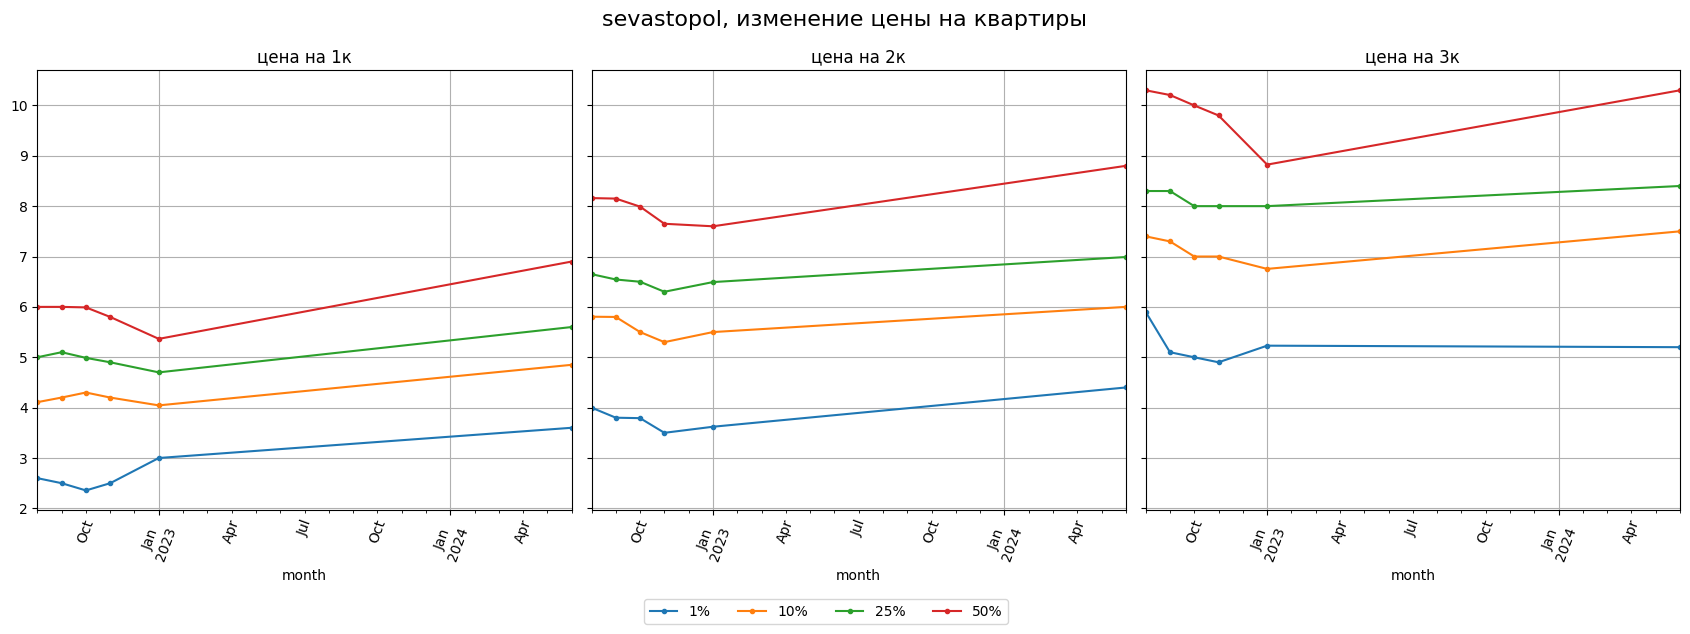

In [26]:
# history_date

place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/panda

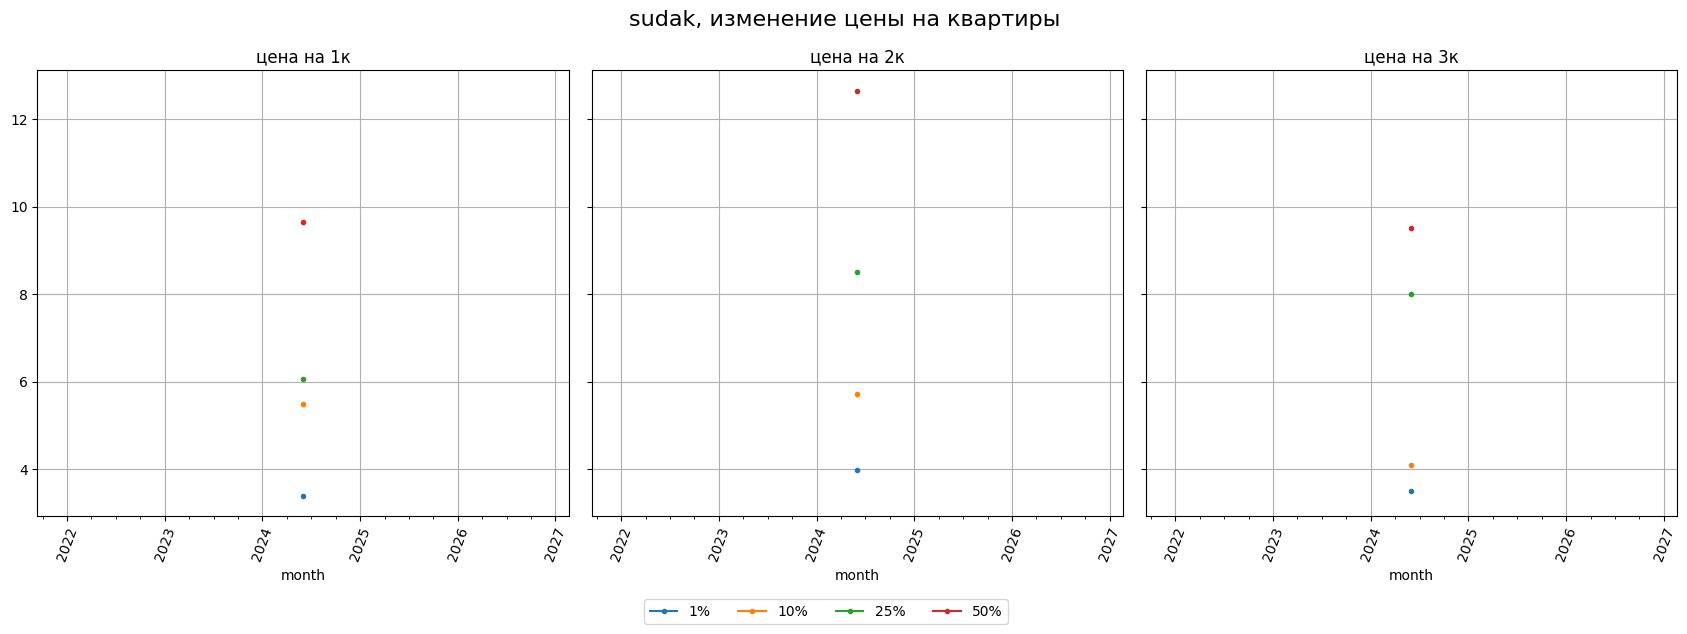

In [27]:
# history_date

place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )


for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [28]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

76036

1877

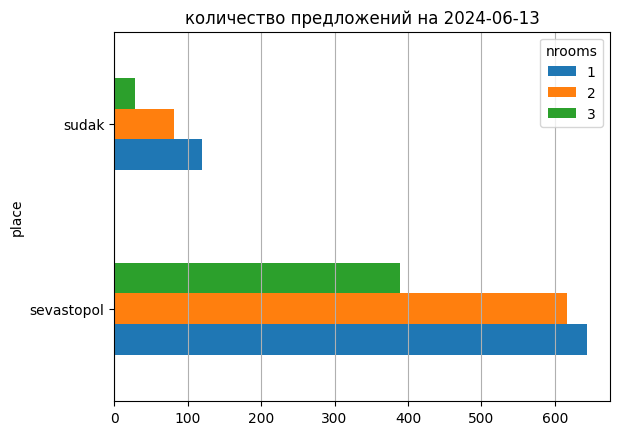

In [29]:
(
gdf_last
.groupby(['nrooms','place'])['url'].count().reset_index()
.pivot(index='place', columns='nrooms', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [30]:
(
    gdf_last
    .groupby(['place','nrooms'])
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std  min   1%   5%  10%  25%   50%   75%  \
place      nrooms                                                          
sevastopol 1      643.00  7.05 1.93 2.70 3.64 4.50 4.91 5.70  7.00  7.85   
           2      617.00  9.27 3.17 3.50 4.42 5.70 6.10 7.00  8.80 10.50   
           3      389.00 11.97 6.23 4.20 5.00 7.04 7.50 8.50 10.50 13.20   
sudak      1      119.00  8.76 2.53 3.30 3.53 4.92 5.46 6.05  9.74 10.66   
           2       81.00 12.43 5.47 3.90 4.14 4.50 5.65 8.30 12.66 15.17   
           3       28.00 11.10 6.01 3.50 3.53 3.74 4.49 8.38  9.55 12.85   

                    90%   95%   max  
place      nrooms                    
sevastopol 1       9.24 10.20 20.00  
           2      13.38 15.50 33.00  
           3      19.34 22.30 85.00  
sudak      1      11.00 11.42 15.53  
           2      20.94 23.33 25.07  
           3      17.36 23.12 30.00

In [31]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

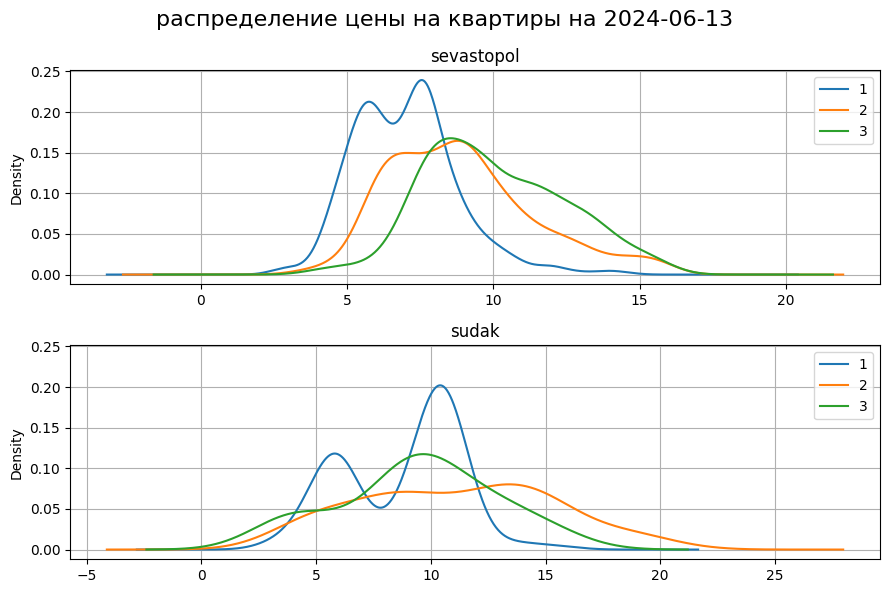

In [32]:
places = ['sevastopol','sudak',]
fig, ax = plt.subplots(len(places),1,figsize=(9,6), sharey=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .query(f'(place=="{p}")&(priceM<{q_95[p]})')
        .groupby(['nrooms'],,observed=True)
        ['priceM'].plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на квартиры на '+ str( gdf_last['dt'].max() ), fontsize=16)
fig.tight_layout()

# цены на карте

In [33]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [34]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

## Севастополь

In [35]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sevastopol.explore()

In [36]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## Судак

In [37]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [38]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [39]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

# display(frames)

In [40]:
frames.explore('area_name', legend=True)

In [41]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
]

In [42]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

In [43]:
# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

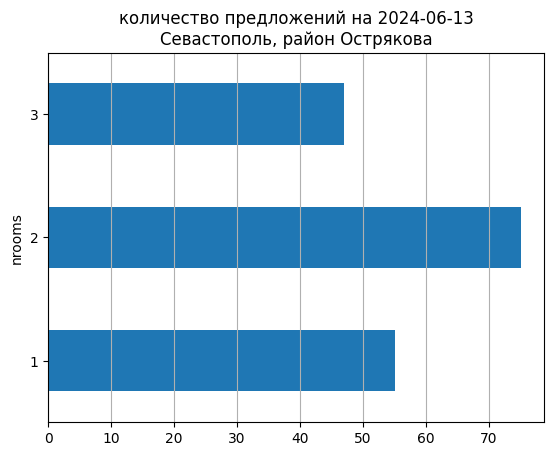

In [44]:
(
    gdf_last_local
    .groupby(['nrooms'])['url'].count()
    .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')   
)

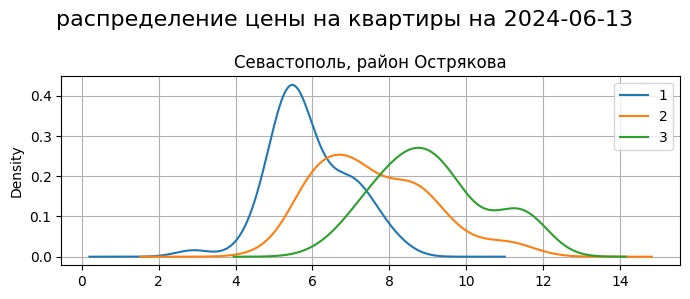

In [49]:
q_95 = gdf_last_local['priceM'].quantile(.95)

fig, ax = plt.subplots(figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    .groupby(['nrooms'],observed=True)
    ['priceM'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
)
fig.suptitle(f'распределение цены на квартиры на '+ str( gdf_last_local['dt'].max() ), fontsize=16)
fig.tight_layout()

----

In [45]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [46]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = gdf_local.groupby(['nrooms','month'],observed=True)['priceM'].describe(percentiles=percentiles)
display( stat )

count  mean  std  min   1%   5%  10%  25%  50%   75%   90%  \
nrooms month                                                                  
1      2022-08  284.00  5.75 1.50 1.85 1.97 3.73 4.10 4.89 5.60  6.80  7.59   
       2022-09 1252.00  5.73 1.33 1.60 2.00 3.60 4.20 4.98 5.65  6.65  7.50   
       2022-10  230.00  5.44 1.43 1.85 2.00 3.27 4.00 4.60 5.35  6.28  7.11   
       2022-11  500.00  5.38 1.38 1.75 1.85 3.25 4.00 4.60 5.30  6.10  7.20   
       2023-01   64.00  5.36 1.27 1.90 2.28 3.63 4.02 4.69 5.19  6.12  7.07   
       2024-06  338.00  5.91 1.11 2.90 2.90 4.60 4.87 5.30 5.65  6.50  7.60   
2      2022-08  380.00  7.97 2.10 4.90 5.30 5.75 6.00 6.50 7.30  8.91 10.90   
       2022-09 1683.00  7.89 2.14 3.60 5.15 5.69 5.85 6.35 7.25  8.60 11.15   
       2022-10  276.00  7.72 2.09 3.65 4.47 5.10 5.45 6.27 7.30  8.60 11.05   
       2022-11  606.00  7.46 2.01 2.65 3.65 5.00 5.30 6.00 7.00  8.30 10.25   
       2023-01   62.00  7.32 2.08 3.65 4.53 5.20 5.50 5.82 6.87  7.76 10.90   
       2024-06  494.00  8.12 2.77 4.50 4.85 5.83 5.90 6.50 7.50  8.80 11.00   
3      2022-08  256.00  9.59 2.30 6.90 6.90 7.00 7.30 7.80 9.00 10.62 13.50   
       2022-09 1005.00  9.69 2.37 6.15 6.70 7.00 7.30 8.00 9.00 10.80 13.50   
       2022-10  173.00  9.46 2.23 6.50 6.50 6.90 7.00 7.90 9.00 10.85 12.70   
       2022-11  401.00  9.52 2.33 6.00 6.20 6.90 7.15 7.89 8.80 10.85 13.10   
       2023-01   48.00  9.85 2.60 6.30 6.34 6.50 6.80 7.96 9.70 10.91 13.65   
       2024-06  302.00  9.65 2.02 6.50 6.50 7.10 7.30 8.30 9.30 11.40 12.39   

                 max  
nrooms month          
1      2022-08 12.00  
       2022-09  9.40  
       2022-10  9.40  
       2022-11  9.65  
       2023-01  8.50  
       2024-06  9.50  
2      2022-08 17.00  
       2022-09 17.00  
       2022-10 16.50  
       2022-11 15.00  
       2023-01 12.80  
       2024-06 22.90  
3      2022-08 16.70  
       2022-09 16.70  
       2022-10 16.70  
       2022-11 16.70  
       2023-01 16.70  
       2024-06 15.50

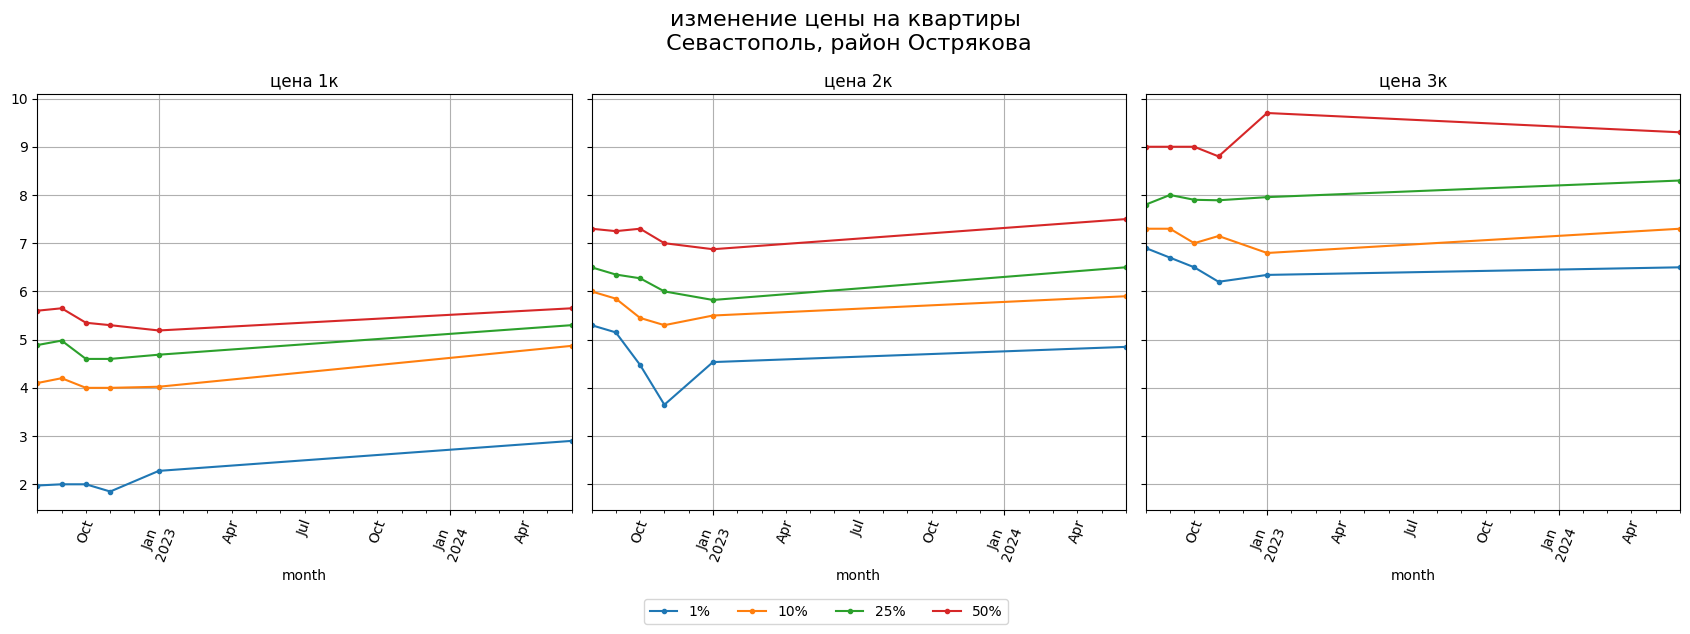

In [47]:
fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на квартиры\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [48]:
# gdf_last_local